In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))


import pandas as pd
import numpy as np
import torch
from games.experiments import EXPERIMENTS
from games.train_open_spiel_player_nr.player_nr_game_wrapper import PlayerNrGameWrapper
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

EXPERIMENT_NAME = "connect_four_configuration_exp_c"
EXPERIMENT = EXPERIMENTS[EXPERIMENT_NAME]
GAME = PlayerNrGameWrapper.from_game_name(EXPERIMENT.game_name)
DIR_PATH = EXPERIMENT.results_dir_path / "model_performances_ppo_vs_random_c/nr_random_moves_2"
RESULTS = pd.read_csv(Path('..') /  DIR_PATH / "results.csv")
RESULTS['PPO_IS_PLAYER0'] = RESULTS['player0'].str.contains('Config')
RESULTS = RESULTS.set_index('match_nr')

NR_GAMES = 5000

2025-03-18 12:15:26.521784: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-18 12:15:26.547188: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-18 12:15:26.547214: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-18 12:15:26.547856: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-18 12:15:26.553172: I tensorflow/core/platform/cpu_feature_guar

In [2]:
def load_game(game_nr, drop_opponent_rows=True):
    game_path = Path('..') / DIR_PATH / f"match_{game_nr}.parquet"
    game =  pd.read_parquet(game_path)
    if drop_opponent_rows:
        is_player_0 = RESULTS.loc[game_nr, 'PPO_IS_PLAYER0']
        start_index = 0 if is_player_0 else 1
        game = game.iloc[start_index::2]

    # last observation after the game is over is None
    if game['action'].iloc[-1] == None:
        game = game.iloc[:-1]

    game['state'] = game['state'].apply(lambda x: x.reshape(4, 6, 7))
    game['move_nr'] = np.array(game.index + 1)
    game['move_nr_from_end'] = game['move_nr'].max() - game['move_nr']
    return game


def load_states(game_nr, drop_opponent_rows=True):
    game = load_game(game_nr, drop_opponent_rows=drop_opponent_rows)
    return game['state']


def get_game_actions(game):
    actions = game['action'].str.slice(1).astype(int)
    return actions.values


def get_move_nr(game_nr, drop_opponent_rows=True):
    game = load_game(game_nr, drop_opponent_rows=drop_opponent_rows)
    return np.array(game.index + 1)


def get_nr_legal_actions(game_nr: int, drop_opponent_rows=True):
    game_data = load_game(game_nr, drop_opponent_rows=False)
    state = get_initial_state(game_data['state'].values[0])
    actions = get_game_actions(game=game_data)
    
    nr_legal_actions = [len(state.legal_actions())]
    for action in actions[:-1]:
        #print(state.to_string())
        state.apply_action(action)
        nr_legal_actions.append(len(state.legal_actions()))

    #print(state.to_string())
    if drop_opponent_rows:
        is_player_0 = RESULTS.loc[game_nr, 'PPO_IS_PLAYER0']
        start_index = 0 if is_player_0 else 1
        nr_legal_actions = nr_legal_actions[start_index::2]
    
    return nr_legal_actions


def get_initial_state(state_array: np.ndarray):
    state = GAME.new_initial_state()
    _apply_moves_to_state(state, state_array[1])
    _apply_moves_to_state(state, state_array[0])   
    return state


def _apply_moves_to_state(state, player_array: np.ndarray):
    assert (player_array == 1).sum() == 1
    # first move needs to be in first or second row
    sum_first_two_rows = player_array[:2].sum(axis=0)
    move_nr = np.argmax(sum_first_two_rows)
    assert sum_first_two_rows[move_nr] == 1
    state.apply_action(move_nr)



In [3]:
def verify_states(game_nr: int):
    game_data = load_game(game_nr, drop_opponent_rows=False)
    state = get_initial_state(game_data['state'].values[0])
    actions = get_game_actions(game=game_data)
    
    replayed_states = []
    features = np.array(state.observation_tensor()).reshape(GAME.observation_tensor_shape())
    replayed_states.append(features)

    # only verifying up to minus one because OpenSpiel's game don't give observation_tensor for the last one
    for action in actions[:-1]:
        state.apply_action(action)
        features = np.array(state.observation_tensor()).reshape(GAME.observation_tensor_shape())
        replayed_states.append(features)
    
    loaded_states = load_states(game_nr, drop_opponent_rows=False)
    assert len(replayed_states) == len(loaded_states)
    for state, state_array in zip(replayed_states, loaded_states):
        assert np.array_equal(state, state_array)


for i in tqdm(range(5000)):
    verify_states(i)

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:21<00:00, 232.11it/s]


In [4]:
games = [load_game(i) for i in tqdm(range(NR_GAMES))]
loaded_states = [state for game in games for state in game['state']]
len(loaded_states)

100%|██████████| 5000/5000 [00:09<00:00, 544.53it/s]


61522

In [5]:
config_predictor = torch.load(Path('..') / EXPERIMENT.ppo_file_path, map_location=DEVICE)
config_predictor.eval()

PPOPolicy(
  (actor): ResNet(
    (first_conv_block): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (res_blocks): Sequential(
      (0): ResNetBlock(
        (conv_block1): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (conv_block2): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): ResNetBlock(
        (conv_block1): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64

In [6]:
# Step size to stay within memory limits
def get_logits_and_values(loaded_states, step_size):
    all_logits = []
    all_values = []

    for i in tqdm(range(0, len(loaded_states), step_size)):
        with torch.no_grad():
            obs = torch.tensor(loaded_states[i:i+step_size], dtype=torch.float32, device=DEVICE)
            logits, _ = config_predictor.actor(dict(obs=obs))
            values = config_predictor.critic(dict(obs=obs))
            all_logits.append(logits.cpu().numpy())
            all_values.append(values.cpu().numpy())

    all_logits = np.concatenate(all_logits)
    all_values = np.concatenate(all_values)
    return all_logits, all_values


all_logits, all_values = get_logits_and_values(loaded_states, step_size=10_000)

  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_472394/2847109100.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  obs = torch.tensor(loaded_states[i:i+step_size], dtype=torch.float32, device=DEVICE)
/home/bart/miniconda3/envs/sdmac_original/lib/python3.11/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 7/7 [00:02<00:00,  3.32it/s]


In [7]:
uct_c_index = all_logits.argmax(axis=1)
c_values = np.array(EXPERIMENT.c_values)[uct_c_index]
pd.Series(c_values).value_counts().sort_index()

0.007812     2218
0.015625     2508
0.031250      716
0.062500      753
0.125000     8840
0.250000    26337
0.500000     4647
1.000000     8524
2.000000     2137
4.000000     4842
Name: count, dtype: int64

In [8]:
def get_action_df(games, c_values):
    legal_actions = [action for game_nr in tqdm(range(NR_GAMES)) for action in get_nr_legal_actions(game_nr=game_nr) ]
    moves_nr = [move_nr for game in games for move_nr in game['move_nr']]
    moves_nr_from_end = [move_nr for game in games for move_nr in game['move_nr_from_end']]
    df = pd.DataFrame(dict(legal_actions=legal_actions, c_values=c_values, move_nr=moves_nr, move_nr_from_end=moves_nr_from_end))
    df['first_player'] = df['move_nr'] % 2 == 1

    print(df['legal_actions'].value_counts().sort_index())
    # filter out states where there is only one legal action, as the configuration value doesn't matter here.
    df = df[df['legal_actions'] > 1]
    
    return df


actions_df = get_action_df(games, c_values)

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:12<00:00, 410.24it/s]


legal_actions
1      813
2     1307
3     2349
4     4046
5     6141
6    12627
7    34239
Name: count, dtype: int64


c_values  0.007812  0.015625  0.031250  0.062500  0.125000  0.250000  \
All           0.04      0.04      0.01      0.01      0.14      0.43   
2             0.01      0.15      0.05      0.02      0.07      0.51   
3             0.01      0.15      0.06      0.01      0.08      0.50   
4             0.01      0.14      0.06      0.02      0.16      0.46   
5             0.02      0.13      0.03      0.00      0.13      0.49   
6             0.01      0.03      0.00      0.00      0.08      0.40   
7             0.06      0.00      0.00      0.02      0.17      0.41   

c_values  0.500000  1.000000  2.000000  4.000000  
All           0.08      0.14      0.03      0.08  
2             0.15      0.02      0.02      0.00  
3             0.12      0.05      0.01      0.01  
4             0.10      0.04      0.00      0.01  
5             0.12      0.04      0.01      0.02  
6             0.06      0.24      0.11      0.06  
7             0.06      0.14      0.02      0.12  


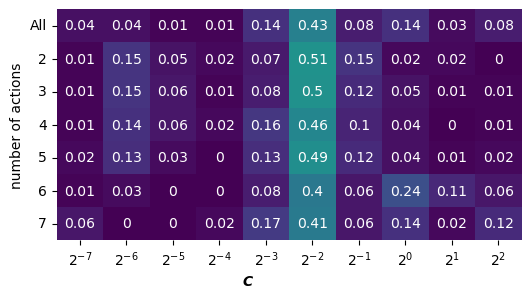

legal_actions
2    0.289224
3    0.328680
4    0.277948
5    0.336234
6    0.821903
7    0.796793
Name: c_values, dtype: float64


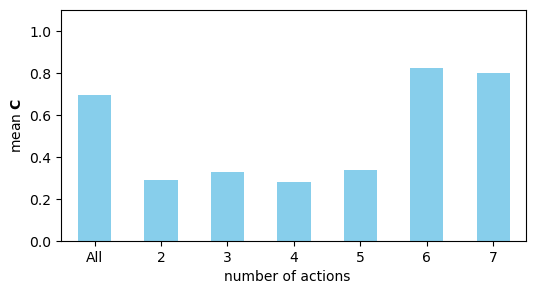

In [9]:
def create_heatmap(df, col, figsize=(12, 6), ylabel=None, yticks_mapping=None):    
    heatmap_data = df.pivot_table(index=col, columns='c_values', aggfunc='size', fill_value=0)
    heatmap_data = heatmap_data.div(heatmap_data.sum(axis=1), axis=0).round(3)

    # Calculate the average distribution of c_values
    avg_distribution = df['c_values'].value_counts(normalize=True).sort_index()
    avg_distribution = pd.DataFrame(avg_distribution).T
    avg_distribution.index = ['All']
    heatmap_data = pd.concat([avg_distribution, heatmap_data])
    heatmap_data = heatmap_data.round(2)

    print(heatmap_data)

    plt.figure(figsize=figsize)
    ax = sns.heatmap(heatmap_data, annot=True, cmap='viridis', cbar=False, vmin=0, vmax=1)

    labels = [f'$2^{{{i}}}$' for i in range(-7, 3)]
    ax.set_xticklabels(labels)
    plt.xticks(rotation=0)  

    plt.xlabel('C', fontweight='bold', fontstyle='italic', x=0.4, ha='left')  # Adjust labelpad to move xlabel to the left
    if yticks_mapping:
        ylabels = [i if i == 'All' else yticks_mapping[i] for i in heatmap_data.index]
        ax.set_yticklabels(ylabels)

    plt.yticks(rotation=0)

    if ylabel:
        plt.ylabel(ylabel)
    else:
        plt.ylabel(col)

    plt.show()


def create_barchart(df, col, figsize=(12, 6), xlabel=None, xticks_mapping=None):
    mean_c_values = df.groupby(col)['c_values'].mean()
    mean_c_values = mean_c_values.sort_index()
    print(mean_c_values)

    mean_all_c_values = pd.Series(dict(All=df['c_values'].mean()))
    mean_c_values = pd.concat([mean_all_c_values, mean_c_values])
    
    plt.figure(figsize=figsize)
    ax = mean_c_values.plot(kind='bar', color='skyblue')
    
    if xticks_mapping:
        xlabels = [i if i == 'All' else xticks_mapping[i] for i in mean_c_values.index]  
        ax.set_xticklabels(xlabels, rotation=0)
    
    plt.xlabel(col if xlabel is None else xlabel, x=0.35, ha='left')
    plt.ylabel('mean $\\mathit{\\mathbf{C}}$')
    plt.xticks(rotation=0)
    plt.ylim(0, 1.1)
    
    plt.show()


def plot_both(df, col, figsize=(6, 3),label=None, ticks_mapping=None):
    create_heatmap(df, col, figsize=figsize, ylabel=label, yticks_mapping=ticks_mapping)
    create_barchart(df, col, figsize=figsize, xlabel=label, xticks_mapping=ticks_mapping)


plot_both(actions_df, 'legal_actions', label='number of actions')

c_values  0.007812  0.015625  0.031250  0.062500  0.125000  0.250000  \
All           0.04      0.04      0.01      0.01      0.14      0.43   
False         0.01      0.14      0.05      0.01      0.13      0.48   
True          0.04      0.01      0.00      0.01      0.15      0.41   

c_values  0.500000  1.000000  2.000000  4.000000  
All           0.08      0.14      0.03      0.08  
False         0.12      0.04      0.01      0.01  
True          0.06      0.17      0.04      0.10  


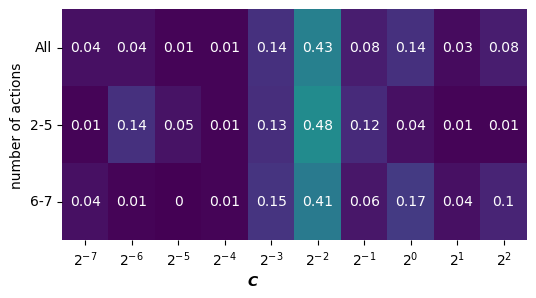

legal_actions_bigger_than_5
False    0.313478
True     0.803558
Name: c_values, dtype: float64


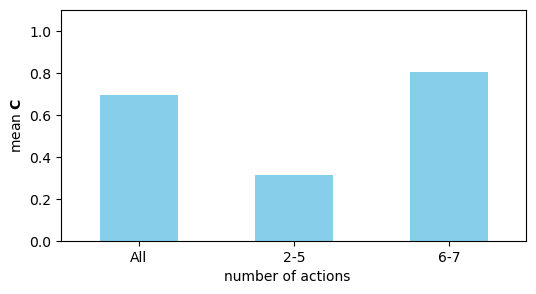

In [10]:
actions_df['legal_actions_bigger_than_5'] = actions_df['legal_actions'] > 5
plot_both(actions_df, 'legal_actions_bigger_than_5', label='number of actions', ticks_mapping={False:'2-5', True:'6-7'})

c_values  0.007812  0.015625  0.031250  0.062500  0.125000  0.250000  \
All           0.04      0.04      0.01      0.01      0.14      0.43   
False         0.06      0.07      0.00      0.01      0.12      0.22   
True          0.02      0.01      0.02      0.02      0.18      0.65   

c_values  0.500000  1.000000  2.000000  4.000000  
All           0.08      0.14      0.03      0.08  
False         0.06      0.26      0.06      0.15  
True          0.09      0.01      0.01      0.00  


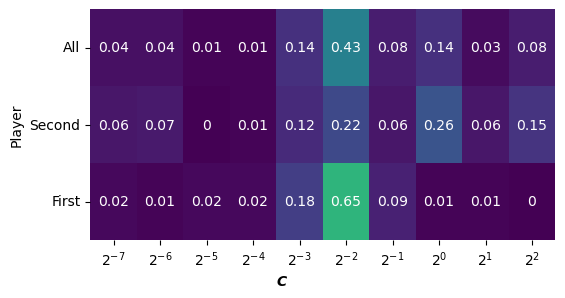

first_player
False    1.067522
True     0.272251
Name: c_values, dtype: float64


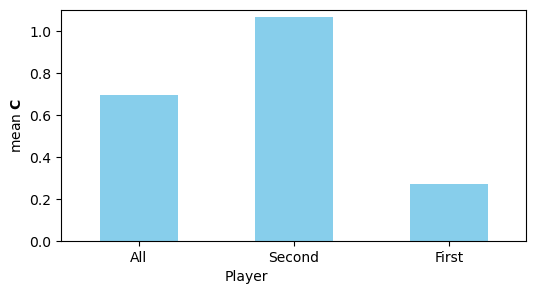

In [11]:
plot_both(actions_df, 'first_player', label='Player', ticks_mapping={False:'Second', True:'First'})

c_values  0.007812  0.015625  0.031250  0.062500  0.125000  0.250000  \
All           0.04      0.04      0.01      0.01      0.14      0.43   
0             0.09      0.00      0.00      0.02      0.32      0.31   
1             0.11      0.00      0.00      0.02      0.23      0.33   
2             0.01      0.00      0.00      0.02      0.14      0.42   
3             0.01      0.00      0.00      0.01      0.06      0.42   
4             0.02      0.05      0.00      0.00      0.09      0.45   
5             0.01      0.10      0.01      0.01      0.08      0.52   
6             0.01      0.11      0.04      0.01      0.11      0.53   
7             0.01      0.11      0.07      0.01      0.10      0.52   
8             0.00      0.12      0.05      0.01      0.08      0.54   
9             0.00      0.14      0.06      0.02      0.05      0.49   

c_values  0.500000  1.000000  2.000000  4.000000  
All           0.08      0.14      0.03      0.08  
0             0.01      0.19     

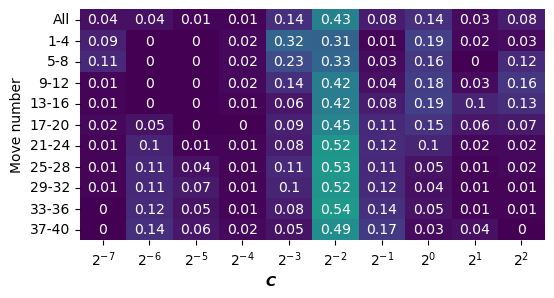

move_nr_div
0    0.494642
1    0.774635
2    1.041280
3    1.054942
4    0.725503
5    0.418083
6    0.350118
7    0.319209
8    0.308947
9    0.336270
Name: c_values, dtype: float64


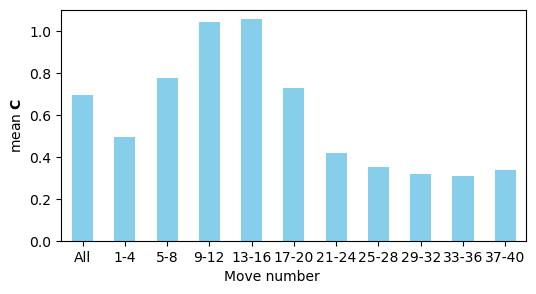

In [12]:
step_size = 4
actions_df['move_nr_div'] =  (actions_df['move_nr'] ) // step_size
ticks_mapping = {i: f'{i*4+1}-{i*4+4}' for i in actions_df['move_nr_div'].unique()}
plot_both(actions_df, 'move_nr_div', label='Move number', ticks_mapping=ticks_mapping)


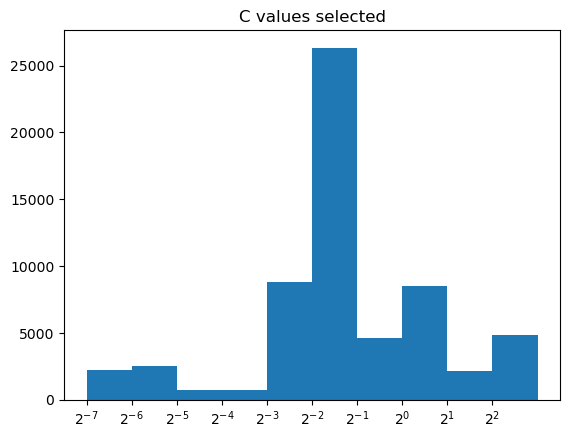

In [13]:
def plot_hist_c_values(c_values, yrange=None, title=''):
    plt.hist(c_values, bins=EXPERIMENT.c_values + [EXPERIMENT.c_values[-1] * 2])
    plt.xscale('log', base=2)
    plt.xticks(EXPERIMENT.c_values)

    if title:
        plt.title(title)
    else:
        plt.title("C values selected")

    if yrange is not None:
        plt.ylim(yrange)

    plt.show()

plot_hist_c_values(c_values)

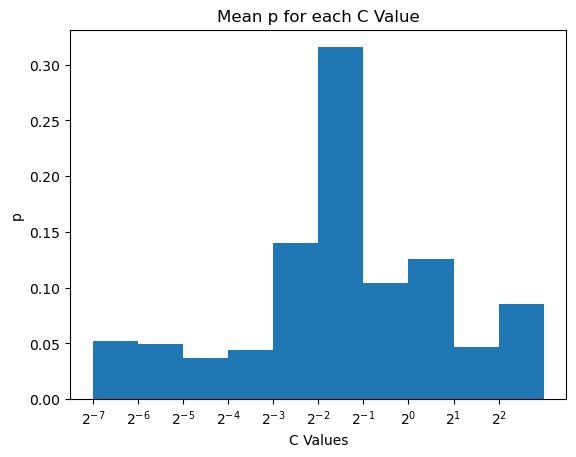

In [14]:
mean_logits = all_logits.mean(axis=0)
plt.bar(x=EXPERIMENT.c_values, height=mean_logits, align='edge',
        width=[2 ** i for i in range(-7, 3)])
plt.xscale('log', base=2)
plt.xlabel('C Values')
plt.xticks(EXPERIMENT.c_values)  # Ensure all c_values are shown on the x-axis
plt.ylabel('p')
plt.title('Mean p for each C Value')
plt.show()